## Assignment interview

### 1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression




### 2. Loading the data

In [2]:
monthly_payment_df = pd.read_csv("Monthly_payments.csv")
user_id_df = pd.read_csv("user_id_table.csv")

In [3]:
#check the monthly payment tables
monthly_payment_df

,user_id,date,payment
0,73,2017-10-01 00:00:00.000000 UTC,1
1,216,2017-10-01 00:00:00.000000 UTC,1
2,3586,2017-10-01 00:00:00.000000 UTC,1
3,4197,2017-10-01 00:00:00.000000 UTC,1
4,4680,2017-10-01 00:00:00.000000 UTC,1
...,...,...,...
198110,47915,2017-12-01 00:00:00.000000 UTC,1
198111,48003,2017-12-01 00:00:00.000000 UTC,1
198112,48774,2017-12-01 00:00:00.000000 UTC,1
198113,49814,2017-12-01 00:00:00.000000 UTC,1


In [4]:
#check the user_id table
user_id_df

,user_id,f_0,f_1,f_2,f_3,f_4
0,117,0.185834,0.257087,0.681947,0.343844,0.562220
1,140,0.274930,0.042934,0.627473,0.534509,0.493101
2,159,0.548740,0.605102,0.369127,0.384560,0.220441
3,175,0.308355,0.600812,0.556980,0.167359,0.453548
4,297,0.724011,0.186172,0.323603,0.579623,0.021604
...,...,...,...,...,...,...
49995,49585,0.691765,0.368827,0.268830,0.536567,0.158915
49996,49751,0.569852,0.289845,0.461525,0.374787,0.487635
49997,49782,0.540032,0.502296,0.185834,0.075061,0.644900
49998,49908,0.420014,0.449307,0.200692,0.535565,0.542775


### 3. Feature engineering
I'm applying feature engineering to the data to derive new insights while avoiding data leakage. Specifically, I will extract temporal features from the date, including the year, quarter, month, and day of the year. Additionally, I will compute the cumulative sum of payments for each user over different time windows.

The reason for using a cumulative sum rather than total payments is to preserve the model’s ability to recognize patterns without introducing data leakage. If I were to include the total payments directly, future information could inadvertently influence predictions, making the model unrealistic for real-world applications. Instead, by computing the cumulative sum, the total payment amount at any given point will accurately reflect the transactions up to that date.

To capture different temporal patterns, I will calculate the cumulative sum of payments at multiple granularities:
- Per year
- Per quarter within each year
- Cumulative sum of the days between the first and last payment up to the given date

In [5]:
#convert the date into pandas.Timestamp and add date features like year, month, quarter etc..
monthly_payment_df["date"] = monthly_payment_df["date"].apply(lambda x: x.split(" ")[0])
monthly_payment_df["date"] = pd.to_datetime(monthly_payment_df["date"])
monthly_payment_df["year"] = monthly_payment_df["date"].dt.year
monthly_payment_df["quarter"] = monthly_payment_df["date"].dt.quarter
monthly_payment_df["month"] = monthly_payment_df["date"].dt.month
monthly_payment_df["dayofyear"] = monthly_payment_df["date"].dt.dayofyear


#joining the table with the user table
df_merged = pd.merge(monthly_payment_df, user_id_df, on="user_id", how="inner")
df_merged = df_merged.sort_values(["user_id", "date"])
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882
...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736


In [6]:
df_merged['days_from_first_date'] = (
    df_merged.groupby('user_id')['date']
    .transform(lambda x: (x - x.min()).dt.days)
)

# Calculate the cumulative sum of payments for each user
df_merged['number_payments_cumulative'] = df_merged.groupby('user_id')['date'].transform('cumcount') + 1  # Start counting from 1

# Calculate the cumulative sum of payments for each user within every year
df_merged['number_payments_cumulative_per_year'] = df_merged.groupby(['user_id', 'year'])['date'].transform('cumcount') + 1  # Start counting from 1

# Calculate the cumulative sum of payments for each user per year per quarter
df_merged['number_payments_cumulative_per_year_per_quarter'] = df_merged.groupby(['user_id', 'year', 'quarter'])['date'].transform('cumcount') + 1  # Start counting from 1
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882,0,1,1,1
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882,29,2,2,2
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882,60,3,3,1
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882,90,4,4,2
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882,121,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594,31,2,2,2
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740,0,1,1,1
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740,31,2,2,2
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736,0,1,1,1


### 4. Creating the target variable
As outlined in the task, the objective is to predict whether a user is likely to miss any payments within the three months following a given date. To create the target variable, the following function assigns values of 0 and 1 based on these criteria:

- If the user has failed payment events within the three months after the given date, the target value will be set to 1. If no such events occur, the target value will be set to 0. Initially, a 90-day window was used for simplicity; however, this doesn't always align perfectly with varying month lengths. To address this, I used the relativedelta function to calculate an exact three-month period from the current date.

- If the user has no payment records after their most recent payment date, or if the time window extends beyond the user's available payment history, I assume the user will miss their next payments, and thus the target value is set to 1.

- The function below might take a while (2/3 mins)

In [7]:
def build_target_variable_rolling(df):
    # Sort by user_id and date
    df = df.sort_values(by=['user_id', 'date']).copy()

    # Compute the maximum date for each user
    user_max_date = df.groupby('user_id')['date'].max().to_dict()

    targets = []

    # Iterate over each row
    for i, row in df.iterrows():
        user_id = row['user_id']
        current_date = row['date']
        end_date = current_date + relativedelta(months=3)

        # Check the max date for the specific user
        max_user_date = user_max_date[user_id]

        # Find future payments within the next 3 months
        future_payments = df[
            (df['user_id'] == user_id) &
            (df['date'] > current_date) &
            (df['date'] <= end_date)
        ]

        # Assign target based on future payments
        target = 0 if not future_payments.empty else 1

        # Handle edge case where the window extends beyond the user's max date
        if end_date > max_user_date:
            target = 1

        targets.append(target)

    # Assign target column
    df['target'] = targets
    return df

df_merged = build_target_variable_rolling(df_merged)
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter,target
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882,0,1,1,1,0
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882,29,2,2,2,0
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882,60,3,3,1,0
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882,90,4,4,2,0
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882,121,5,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594,31,2,2,2,1
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740,0,1,1,1,1
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740,31,2,2,2,1
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736,0,1,1,1,1


#### 4.1 Feature engineering on constant variables

- I also considered exploring clustering to identify patterns or trends that could highlight specific groups of users likely to churn. However, clustering methods typically assume that each data point is an independent observation. In this case, we have users appearing multiple times, which could potentially bias the clusters.
Alternatively, I could restructure the data by aggregating it at the user level and providing summary statistics for other features. However, this approach could result in losing the sequential nature of payments, which is an important aspect of understanding user behavior. Furthermore, aggregating the data in this way could alter the target variable and reduce the model’s ability to capture time-based patterns.


- However, we can observe the distribution of the churn rate in relation to the total number of payments and the total number of days from the first payment to the last. As shown in the chart, most users appear to churn within the first month. In terms of absolute days, the peak churn rate seems to occur between the 25th and 50th day.



C:\Users\matte\AppData\Local\Temp\ipykernel_3052\2049027859.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=cluster_history_payments, x="number_payments_cumulative", binwidth=3, element="step", palette=palette, kde=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_3052\2049027859.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=cluster_history_payments, x="days_from_first_date", palette=palette)


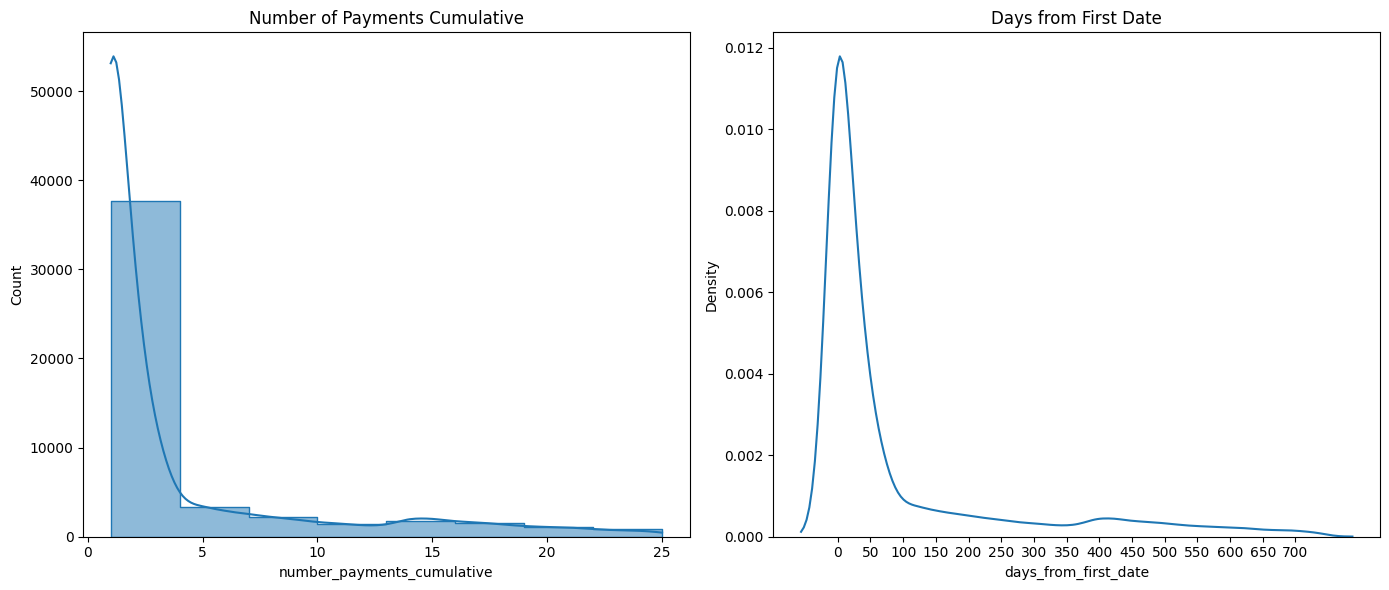

In [8]:
# Group by 'cluster' and calculate the last value for 'number_payments_cumulative'
cluster_history_payments = df_merged.groupby(["user_id"]).agg({'number_payments_cumulative': 'last', "days_from_first_date": "last"})
cluster_history_payments = cluster_history_payments.reset_index()
#cluster_history_payments.groupby("cluster").agg({"number_payments_cumulative": "mean"})

# Set figure size
plt.figure(figsize=(14, 6))
palette = ["red", "green", "blue"]
# Create a 1x2 grid of subplots (2 charts in a row)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(data=cluster_history_payments, x="number_payments_cumulative", binwidth=3, element="step", palette=palette, kde=True)
plt.title('Number of Payments Cumulative')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.kdeplot(data=cluster_history_payments, x="days_from_first_date", palette=palette)
# Example 1a: Specific tick positions
plt.xticks([0, 20, 100, 200, 300, 400, 500, 700])  # Set ticks at these values

# Example 1b: Ticks at regular intervals
min_val = cluster_history_payments['days_from_first_date'].min()
max_val = cluster_history_payments['days_from_first_date'].max()
interval = 50  # desired interval
plt.xticks(range(min_val, max_val + 1, interval))


plt.title('Days from First Date')

# Show the plot
plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()


### 5. Consideration before training machine learning models
Upon further analysis of the data and visualizing the samples with a box plot, it is evident that the distribution is highly right-skewed (positive skew). This is apparent because the majority of the data is concentrated at the lower end of the "days_from_first_date" values, close to 0, while a long tail extends to the right, containing numerous outliers. Best practices would suggest removing these outliers and focusing on the majority of the samples located on the left side of the chart. However, assuming the data is accurate and does not contain errors related to failing payment events, I would recommend training different models based on customer retention behavior within the company.

This approach has both pros and cons:
- On the one hand, a single model is easier to maintain in a production environment, leading to reduced computational costs, especially when dealing with a large customer base. On the other hand, a single model may struggle to capture the full spectrum of user behavior, which could reduce its overall accuracy. Additionally, training a model on diverse patterns could increase the risk of underfitting, particularly if there are significant differences in the churn behavior of different customer segments.

- Conversely, using multiple models for different segments can be risky if the segments are too small, potentially leading to data scarcity in some segments and less robust models. Moreover, the increased complexity of managing multiple models can be resource-intensive.

Given the specific case, I would recommend a hybrid approach: training one model for customers who churn in a short period and another for long-term users. This way, we can capture distinct behaviors without compromising model performance.
To begin, I’ll first train a single model for all customers and another for specific user segments to see if my hypotheses are validated.

<Axes: xlabel='days_from_first_date'>

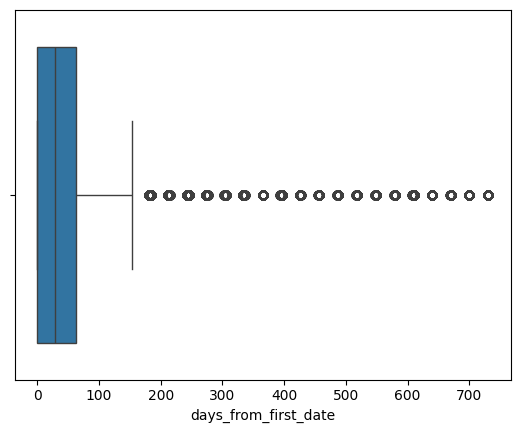

In [9]:
sns.boxplot(x=cluster_history_payments["days_from_first_date"])


In [10]:
# Define conditions for each class
conditions = [
    (cluster_history_payments["days_from_first_date"] >= 500),  # For "big"
    (cluster_history_payments["days_from_first_date"] > 200),  # For "medium"
    (cluster_history_payments["days_from_first_date"] <= 200)  # For "small"
]

# Define corresponding class labels
choices = ["big", "medium", "small"]

# Assign the class labels to the 'cluster' column based on the conditions
cluster_history_payments["cluster"] = np.select(conditions, choices, default="unknown")
cluster_history_payments

,user_id,number_payments_cumulative,days_from_first_date,cluster
0,0,24,700,big
1,1,1,0,small
2,2,1,0,small
3,3,1,0,small
4,4,1,0,small
...,...,...,...,...
49995,49995,1,0,small
49996,49996,2,31,small
49997,49997,2,31,small
49998,49998,1,0,small


### 6. Splitting the data
To ensure proper data splitting before training the model and to account for all possible behavioral patterns among users, I will split the data at the user level. This approach will preserve the sequential nature of the payments and maintain different distributions across the training, validation, and test sets. Failing to do so could lead to the model learning only the patterns of specific users, limiting its ability to generalize when faced with customers exhibiting entirely different behaviors.

In [11]:
train_users = []
val_users = []
test_users = []

for element in choices:
    filtered_users = cluster_history_payments.groupby("cluster")["user_id"].unique()[element]
    train, temp = train_test_split(filtered_users, test_size=0.4, random_state=42)  # 60% train
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 20% val, 20% test

    # # Add the resulting user_ids to the appropriate lists
    train_users.append(train.tolist())
    val_users.append(val.tolist())
    test_users.append(test.tolist())

# Combine all the train, val, and test user_ids into a single list if needed
train_users = [item for sublist in train_users for item in sublist]
val_users = [item for sublist in val_users for item in sublist]
test_users = [item for sublist in test_users for item in sublist]

df_merged['train'] = df_merged['user_id'].isin(train_users)
df_merged['val'] = df_merged['user_id'].isin(val_users)
df_merged['test'] = df_merged['user_id'].isin(test_users)

df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter,target,train,val,test
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882,0,1,1,1,0,True,False,False
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882,29,2,2,2,0,True,False,False
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882,60,3,3,1,0,True,False,False
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882,90,4,4,2,0,True,False,False
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882,121,5,5,3,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594,31,2,2,2,1,True,False,False
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740,0,1,1,1,1,True,False,False
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740,31,2,2,2,1,True,False,False
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736,0,1,1,1,1,False,False,True


In [12]:
#setting train set
X_train = df_merged[df_merged["train"]==True].drop(["user_id", "date", "train", "val", "test", "target"], axis = 1)
y_train = df_merged[(df_merged["train"]==True)]["target"]

#setting validations set
X_val = df_merged[df_merged["val"]==True].drop(["user_id", "date", "train", "val", "test","target"], axis = 1)
y_val = df_merged[(df_merged["val"]==True)]["target"]

#setting test set
X_test = df_merged[df_merged["test"]==True].drop(["user_id", "date", "train", "val", "test", "target"], axis = 1)
y_test = df_merged[(df_merged["test"]==True)]["target"]

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((119104, 14), (119104,), (39426, 14), (39426,), (39585, 14), (39585,))

### 7. Training the model

#### 7.1 Applying XGBoost
XGBoost was selected due to its strong performance in both regression and classification tasks.  My experience indicates it offers a good balance of accuracy and training speed, often outperforming algorithms like logistic regression and SVM in terms of training time.  To optimize performance and avoid overfitting, the model was trained with a moderate number of trees and a carefully chosen learning rate.

In [14]:
# Train XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    early_stopping_rounds = 150
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-logloss:0.66181	validation_1-logloss:0.66198
[1]	validation_0-logloss:0.63905	validation_1-logloss:0.63939
[2]	validation_0-logloss:0.62020	validation_1-logloss:0.62056
[3]	validation_0-logloss:0.60460	validation_1-logloss:0.60516
[4]	validation_0-logloss:0.59162	validation_1-logloss:0.59222
[5]	validation_0-logloss:0.58071	validation_1-logloss:0.58136
[6]	validation_0-logloss:0.57152	validation_1-logloss:0.57218
[7]	validation_0-logloss:0.56369	validation_1-logloss:0.56444
[8]	validation_0-logloss:0.55670	validation_1-logloss:0.55753
[9]	validation_0-logloss:0.55073	validation_1-logloss:0.55166
[10]	validation_0-logloss:0.54588	validation_1-logloss:0.54689
[11]	validation_0-logloss:0.54138	validation_1-logloss:0.54255
[12]	validation_0-logloss:0.53749	validation_1-logloss:0.53877
[13]	validation_0-logloss:0.53414	validation_1-logloss:0.53555
[14]	validation_0-logloss:0.53129	validation_1-logloss:0.53278
[15]	validation_0-logloss:0.52879	validation_1-logloss:0.53030
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=150,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### 8. Results
Based on the following classification report, the model appears to predict the target variable accurately 74% of the time, both for churn and no churn. However, when we delve deeper into the precision and recall, a clearer picture emerges.

- Starting with precision, which measures the proportion of customers predicted to churn who actually do, the model achieves a precision of 74%. This means that 74% of the customers flagged as likely to churn in the next three months indeed did churn.

- On the other hand, the recall is 68%, indicating that the model correctly identifies 68% of the customers who actually fail to pay in the next three months.

In summary, when the model predicts that a customer will churn in the next three months, it is correct 74% of the time. Since precision is higher than recall, this suggests that the model is more cautious about predicting churn. It is less likely to mistakenly label a customer as churning when they will not. However, with a recall of 68%, the model is missing around 32% of customers who should have been predicted to churn.

Depending on the business context, particularly if the cost of missing a churn prediction (false negatives) is high, it may be worth focusing on improving recall. In this scenario, I would prefer a model that errs on the side of caution, even if it means generating more false positives, as failing to identify churners could have more significant consequences for the company.

In [15]:
# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC

# Metrics
print("Test Set Metrics:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     21378
           1       0.74      0.68      0.71     18207

    accuracy                           0.74     39585
   macro avg       0.74      0.74      0.74     39585
weighted avg       0.74      0.74      0.74     39585

ROC-AUC: 0.810


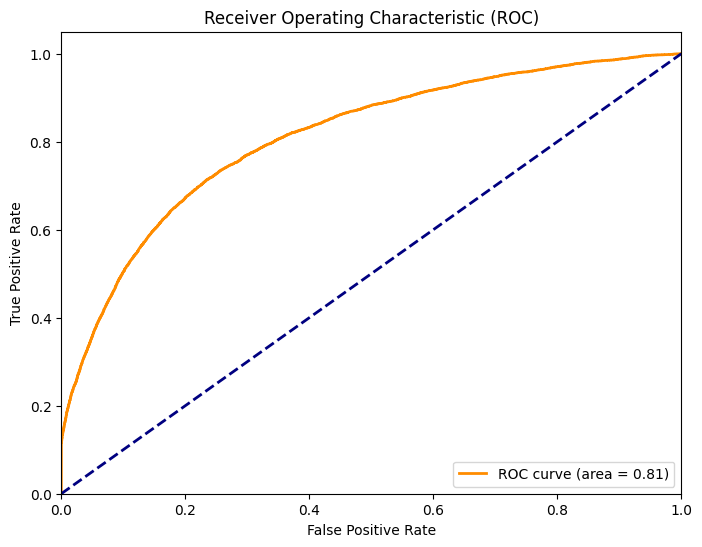

In [16]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_proba) # For binary classification
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Dashed diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

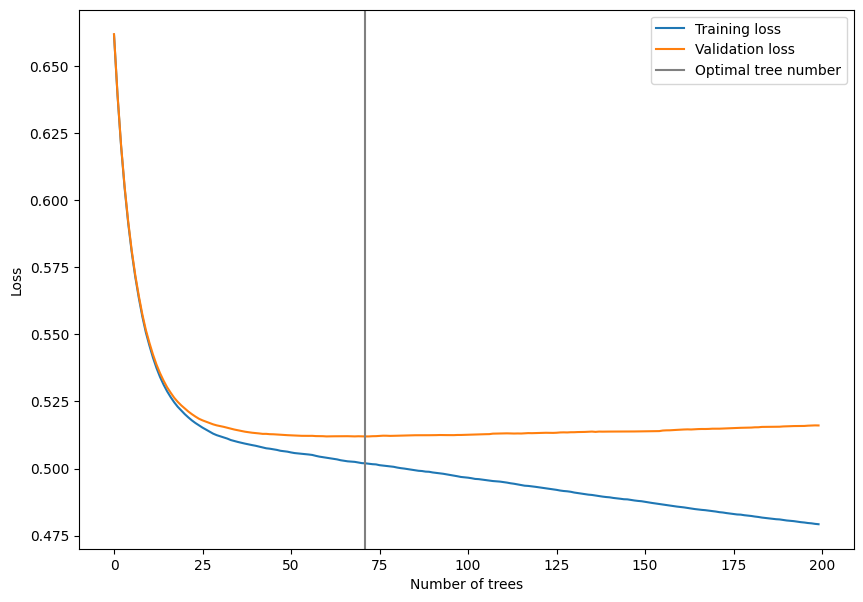

In [17]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(71, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

(<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>,
 <Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>)

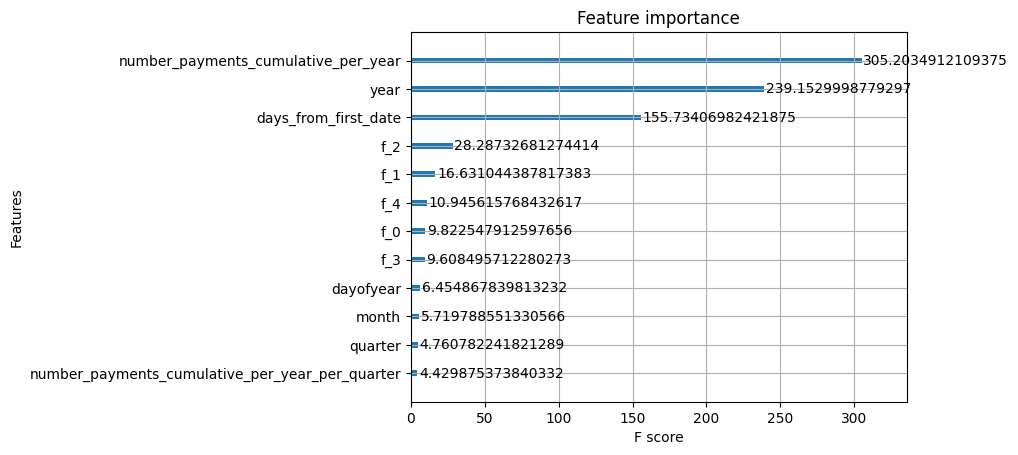

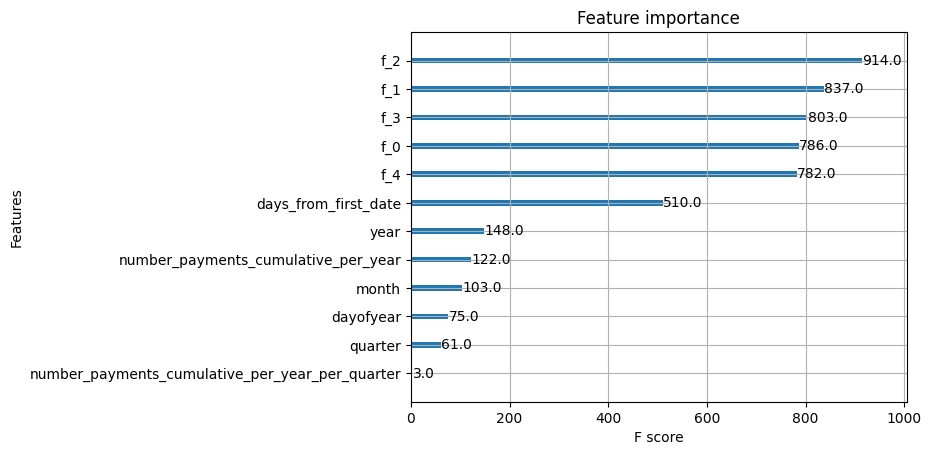

In [18]:
xgb.plot_importance(model, importance_type = "gain"), xgb.plot_importance(model, importance_type = "weight")

#### 8.2 Results with multiple models

In [19]:
df_merged_2 = df_merged.copy()
df_merged_2 = df_merged_2.drop(["train", "val", "test"], axis = 1)


cluster_history_payments = df_merged_2.groupby(["user_id"]).agg({'number_payments_cumulative': 'last', "days_from_first_date": "last"})
cluster_history_payments = cluster_history_payments.reset_index()

In [20]:
def split_dataframe_by_user(df, user_ids, test_size=0.2, val_size=0.2, random_state=42):

    # Split user_ids into train and temp (val + test)
    train_users, temp_users = train_test_split(user_ids, test_size=(test_size + val_size), random_state=random_state)

    # Split temp_users into val and test
    val_users, test_users = train_test_split(temp_users, test_size=test_size / (test_size + val_size), random_state=random_state)

    # Assign each row in df to the corresponding set based on user_id
    df_train = df[df["user_id"].isin(train_users)]
    df_val = df[df["user_id"].isin(val_users)]
    df_test = df[df["user_id"].isin(test_users)]

    # Separate features (X) and target (y)
    X_train, y_train = df_train.drop(columns=["user_id", "date", "target"]), df_train["target"]
    X_val, y_val = df_val.drop(columns=["user_id", "date", "target"]), df_val["target"]
    X_test, y_test = df_test.drop(columns=["user_id", "date", "target"]), df_test["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
def train_and_evaluate_model(df_merged_2, cluster_history_payments, days_from_first_date):

    #merged_3 = df_merged_2.copy()

    #short-lasting customers
    big_users = cluster_history_payments[cluster_history_payments["days_from_first_date"] > days_from_first_date]["user_id"].to_list()
    cluster_history_payments = cluster_history_payments[~cluster_history_payments["user_id"].isin(big_users)]

    # Define conditions for each class
    conditions = [
        (cluster_history_payments["days_from_first_date"] >= days_from_first_date - 50),  # For "big"
        (cluster_history_payments["days_from_first_date"] > days_from_first_date - 100),  # For "medium"
        (cluster_history_payments["days_from_first_date"] <= days_from_first_date - 200)  # For "small"
    ]

    # Define corresponding class labels
    choices = ["big", "medium", "small"]

    # Assign the class labels to the 'cluster' column based on the conditions
    cluster_history_payments["cluster"] = np.select(conditions, choices, default="unknown")

    train_users = []
    val_users = []
    test_users = []

    for element in choices:
        filtered_users = cluster_history_payments.groupby("cluster")["user_id"].unique()[element]
        train, temp = train_test_split(filtered_users, test_size=0.4, random_state=42)  # 60% train
        val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 20% val, 20% test

        # # Add the resulting user_ids to the appropriate lists
        train_users.append(train.tolist())
        val_users.append(val.tolist())
        test_users.append(test.tolist())

    # Combine all the train, val, and test user_ids into a single list if needed
    train_users = [item for sublist in train_users for item in sublist]
    val_users = [item for sublist in val_users for item in sublist]
    test_users = [item for sublist in test_users for item in sublist]

    df_merged_2['train'] = df_merged_2['user_id'].isin(train_users)
    df_merged_2['val'] = df_merged_2['user_id'].isin(val_users)
    df_merged_2['test'] = df_merged_2['user_id'].isin(test_users)

    #setting train set
    X_train = df_merged_2[df_merged_2["train"]==True].drop(["user_id", "date", "train", "val", "test", "target"], axis = 1)
    y_train = df_merged_2[(df_merged_2["train"]==True)]["target"]

    #setting validations set
    X_val = df_merged_2[df_merged_2["val"]==True].drop(["user_id", "date", "train", "val", "test",  "target"], axis = 1)
    y_val = df_merged_2[(df_merged_2["val"]==True)]["target"]

    #setting test set
    X_test = df_merged_2[df_merged_2["test"]==True].drop(["user_id", "date", "train", "val", "test", "target"], axis = 1)
    y_test = df_merged_2[(df_merged_2["test"]==True)]["target"]

    # Train XGBoost
    model_2 = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        early_stopping_rounds = 150
    )

    model_2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
    # Predict on test set
    y_pred = model_2.predict(X_test)
    y_proba = model_2.predict_proba(X_test)[:, 1]  # Probabilities for AUC

    # Metrics
    print("Test Set Metrics:")
    report = classification_report(y_test, y_pred)
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

    #big users
    # Apply the function to your DataFrame
    X_train_big, y_train_big, X_val_big, y_val_big, X_test_big, y_test_big = split_dataframe_by_user(df_merged_2, big_users)


    # # Train XGBoost
    model_3 = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        early_stopping_rounds = 150
    )

    model_3.fit(X_train_big, y_train_big, eval_set=[(X_train_big, y_train_big), (X_val_big, y_val_big)])

    # Predict on test set
    y_pred_big = model_3.predict(X_test_big)
    y_proba_big = model_3.predict_proba(X_test_big)[:, 1]  # Probabilities for AUC

    # # Metrics
    report_big = classification_report(y_test_big, y_pred_big)
    print(f"ROC-AUC: {roc_auc_score(y_test_big, y_proba_big):.3f}")

    return {
        'short-lasting-cutomers': report,
        'long-lasting-cutomers': report_big,
        }


results = train_and_evaluate_model(df_merged_2, cluster_history_payments, days_from_first_date=400)
print("\n\n Short lasting customers Classification Report:\n", results['short-lasting-cutomers'])
print("\n\n Long lasting customers Classification Report:\n", results['long-lasting-cutomers'])


[0]	validation_0-logloss:0.58059	validation_1-logloss:0.57878
[1]	validation_0-logloss:0.56601	validation_1-logloss:0.56402
[2]	validation_0-logloss:0.55441	validation_1-logloss:0.55230
[3]	validation_0-logloss:0.54478	validation_1-logloss:0.54254
[4]	validation_0-logloss:0.53669	validation_1-logloss:0.53437
[5]	validation_0-logloss:0.53005	validation_1-logloss:0.52757
[6]	validation_0-logloss:0.52466	validation_1-logloss:0.52203
[7]	validation_0-logloss:0.51991	validation_1-logloss:0.51715
[8]	validation_0-logloss:0.51569	validation_1-logloss:0.51296
[9]	validation_0-logloss:0.51218	validation_1-logloss:0.50944
[10]	validation_0-logloss:0.50933	validation_1-logloss:0.50675
[11]	validation_0-logloss:0.50664	validation_1-logloss:0.50404
[12]	validation_0-logloss:0.50450	validation_1-logloss:0.50196
[13]	validation_0-logloss:0.50266	validation_1-logloss:0.50004
[14]	validation_0-logloss:0.50101	validation_1-logloss:0.49842
[15]	validation_0-logloss:0.49953	validation_1-logloss:0.49702
[1

C:\Users\matte\AppData\Local\Temp\ipykernel_3052\4014398898.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_history_payments["cluster"] = np.select(conditions, choices, default="unknown")


[30]	validation_0-logloss:0.48679	validation_1-logloss:0.48617
[31]	validation_0-logloss:0.48641	validation_1-logloss:0.48596
[32]	validation_0-logloss:0.48605	validation_1-logloss:0.48579
[33]	validation_0-logloss:0.48552	validation_1-logloss:0.48533
[34]	validation_0-logloss:0.48507	validation_1-logloss:0.48506
[35]	validation_0-logloss:0.48456	validation_1-logloss:0.48477
[36]	validation_0-logloss:0.48405	validation_1-logloss:0.48460
[37]	validation_0-logloss:0.48364	validation_1-logloss:0.48435
[38]	validation_0-logloss:0.48342	validation_1-logloss:0.48430
[39]	validation_0-logloss:0.48313	validation_1-logloss:0.48427
[40]	validation_0-logloss:0.48287	validation_1-logloss:0.48421
[41]	validation_0-logloss:0.48259	validation_1-logloss:0.48417
[42]	validation_0-logloss:0.48212	validation_1-logloss:0.48393
[43]	validation_0-logloss:0.48166	validation_1-logloss:0.48369
[44]	validation_0-logloss:0.48122	validation_1-logloss:0.48342
[45]	validation_0-logloss:0.48102	validation_1-logloss:

## 9. Conclusion

After training two distinct models based on user segments—one for long-term customers (those with more than 400 days in the company) and another for short-term customers (those with fewer than 400 days)—we can validate our initial hypothesis. The results indicate that using separate models allows for a more cautious approach in identifying customers at risk of failing to pay within the next three months.

Notably, the recall for short-term customers has improved to 94%, while for long-term customers, it remains slightly lower at 80%. This suggests that if minimizing churn (false negatives) is a priority, adopting a hybrid approach with two specialized models per customer segment may be effective, even if it leads to a higher number of false alarms (false positives).